# **Esempio 4. Rete neurale a 2 livelli per la regressione di proprietà chimico-fisiche di derivati del metano**

In questo esempio verrà addestrata una rete neurale a 2 livelli per la regressione della temperatura di ebollizione e l'entalpia standard di formazione su un dataset di derivati del metano, costruiti da un insieme  limitato di sostituenti, in particolare: H, F, Cl, Br, I.

Si useranno come descrittori molecolari:

* la costante dielettrica della fase liquida,

* il valore assoluto del momento di dipolo elettrico molecolare,

* le tre componenti principali del tensore di inerzia,

* il raggio di Van der Waals molecolare,

* la massa molare.


Dato che si tratta di regressione, per le unità nascoste sarà conveniente utilizzare la funzione ReLU (*rectified linear unit*):

\begin{equation}
f(\mathbf{w}\cdot\mathbf{X})=\left\{
  \begin{array}{ll}
  0&\mbox{se }\mathbf{w}\cdot\mathbf{X}\le0\\
  \mathbf{w}\cdot\mathbf{X}&\mbox{altrimenti}
  \end{array}
  \right.=\max\{0, \mathbf{w}\cdot\mathbf{X}\}
\end{equation}

Se necessario, si installino prima le seguenti libreerie.

In [1]:
%%capture
!pip install rdkit
!pip install git+https://github.com/mordred-descriptor/mordred
!pip install py3Dmol

La cella che segue richiama le librerie che serviranno.

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

import pandas as pd
import numpy as np

## **Dataset**
Si carica il dataset di esempi in un `DataFrame` di `pandas`.

In [3]:
url = 'https://drive.google.com/file/d/13Btl50jjYsXt5kY_kzeSwVQ6gbvVCozt/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

data = pd.read_table(url, encoding='windows-1252', delimiter=';')

display(data)

Cabcd         SMILES  epsilon       d      I1      I2      I3       r  \
0       CH4              C     8.80  0.0005  0.0032  0.0032  0.0032  120.00   
1       CF4      FC(F)(F)F    15.92  0.0027  0.0909  0.0910  0.0910  147.00   
2      CCl4  ClC(Cl)(Cl)Cl    12.64  0.0015  0.2927  0.2929  0.2929  175.00   
3      CBr4  BrC(Br)(Br)Br    11.84  0.0011  0.7934  0.7938  0.7938  185.00   
4       CI4      IC(I)(I)I    10.64  0.0003  1.5348  1.5356  1.5356  198.00   
5      CH3F             CF    10.58  2.2975  0.0032  0.0361  0.0361  126.75   
6     CH2F2            FCF    12.36  2.6538  0.0252  0.0471  0.0690  133.50   
7      CHF3         FC(F)F    14.14  2.3004  0.0581  0.0581  0.0909  140.25   
8     CH3Cl            CCl     9.76  1.4549  0.0032  0.1118  0.1118  133.75   
9    CH2C12          ClCCl    10.72  1.6805  0.0757  0.1480  0.2204  147.50   
10    CHCI3      ClC(Cl)Cl    11.68  1.4566  0.1843  0.1843  0.2927  161.25   
11    CH3Br            CBr     9.56  1.1726  0.0032  0.2996  0.2996  136.25   
12   CH2Br2          BrCBr    10.32  1.3544  0.2010  0.3983  0.5961  152.50   
13    CHBr3      BrC(Br)Br    11.08  1.1739  0.4974  0.4974  0.7934  168.75   
14     CH3I             CI     9.26  0.6156  0.0032  0.5777  0.5777  139.50   
15    CH2I2            ICI     9.72  0.7110  0.3865  0.7690  1.1523  159.00   
16     CHI3         IC(I)I    10.18  0.6161  0.9611  0.9611  1.5348  178.50   
17    CF3Cl     ClC(F)(F)F    15.10  0.8417  0.0910  0.1666  0.1667  154.00   
18   CF2Cl2    FC(F)(Cl)Cl    14.28  0.9717  0.1415  0.1919  0.2424  161.00   
19    CFCI3   FC(Cl)(Cl)Cl    13.46  0.8411  0.2172  0.2172  0.2927  168.00   
20    CF3Br     BrC(F)(F)F    14.90  1.1240  0.0910  0.3545  0.3545  156.50   
21   CF2Br2    FC(F)(Br)Br    13.88  1.2978  0.2668  0.4422  0.6180  166.00   
22    CFBr3   FC(Br)(Br)Br    12.86  1.1238  0.5303  0.5303  0.7934  175.50   
23     CF3I      IC(F)(F)F    14.60  1.6810  0.0910  0.6326  0.6326  159.75   
24    CF2I2      FC(F)(I)I    13.28  1.9412  0.4523  0.8129  1.1742  172.50   
25     CFI3      FC(I)(I)I    11.96  1.6816  0.9940  0.9940  1.5348  185.25   
26   CCl3Br  BrC(Cl)(Cl)Cl    12.44  0.2818  0.2929  0.4806  0.4807  177.50   
27  CCl2Br2  BrC(Br)(Cl)Cl    12.24  0.3252  0.4182  0.5432  0.6684  180.00   
28   CClBr3  ClC(Br)(Br)Br    12.04  0.2812  0.6060  0.6060  0.7934  182.50   

            M     peb     DHf(g)  
0    16.04246  111.75  -74.87000  
1    88.00430  145.30 -930.00000  
2   153.82270  349.87  -95.81360  
3   331.62670  462.80   79.49600  
4   519.62670  602.35  267.94336  
5    34.03292  194.75 -233.89000  
6    52.02338  221.55 -452.30000  
7    70.01384  191.05 -695.40000  
8    50.48752  249.06  -81.90000  
9    84.93258  313.15  -94.55840  
10  119.37764  334.32 -102.92640  
11   94.93852  276.65  -35.40000  
12  173.83458  370.15  -14.76952  
13  252.73064  414.25   16.73600  
14  141.93852  315.58   13.76536  
15  267.83458  455.15  117.57040  
16  393.73064  491.15  210.87360  
17  104.45890  191.75 -706.30000  
18  120.91350  243.35 -477.40000  
19  137.36810  296.85 -268.30000  
20  148.90990  215.35 -648.30000  
21  209.81550  295.91 -386.60000  
22  270.72110  381.15 -143.46936  
23  195.90990  250.65 -587.80000  
24  303.81550  374.15 -274.80512  
25  411.72110  477.15   11.00392  
26  198.27370  378.15  -38.91120  
27  242.72470  423.35    9.28848  
28  287.17570  377.45   48.74360

La cella che segue utilizza i *widgets* di Python per rappresentare i punti della *scatter matrix* usando come codice colore la temperatura di ebollizione oppure l'entalpia standard di formazione.

In [4]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def sm(Label):
  plt.clf()
  features = ['epsilon', 'd', 'I1', 'I2', 'I3', 'r', 'M']
  colors = data[Label]
  pd.plotting.scatter_matrix(data[features], c = colors, figsize=(10, 10), marker='o', hist_kwds={'bins': 20}, s=50, alpha=0.8)
  plt.show()

# Dropdown menù per la scelta della specie
interact(sm, Label = ['peb', 'DHf(g)']);

interactive(children=(Dropdown(description='Label', options=('peb', 'DHf(g)'), value='peb'), Output()), _dom_c…

## **Rete neurale**
Creiamo una rete neurale a 2 livelli, con 4 neuroni nel livello nascoto, all'interno del quale si utilizza la funzione ReLU per la non linearità.


Come primo passo, si scelgono i descrittori, l'etichetta associata, e si partizionano gli esempi in addestramento e testing.

In [14]:
features = ['epsilon', 'd', 'I1', 'I2', 'I3', 'r', 'M']
labels=['DHf(g)'] # scegliere tra 'peb' o 'DHf(g)' per, rispettivamente, temperatura di ebollizione o entalpia standard di formazione

X = data[features]
y = data[labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training e 30% test

Adesso definiamo e addestriamo la rete neurale di regressione.

In [12]:
clf = MLPRegressor(hidden_layer_sizes=(4,), activation='relu', solver='lbfgs', alpha=1e-5, random_state=1, max_iter=1000)

clf.fit(X_train, y_train.to_numpy().ravel())

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(4,), max_iter=1000,
             random_state=1, solver='lbfgs')

Segue la fase di testing.

DHf(g)  Predizione
0   13.76536   11.622817
1 -386.60000 -402.747469
2 -477.40000 -493.734035
3 -648.30000 -655.056899
4   11.00392   16.211502
5 -268.30000 -290.355439
6   79.49600   64.658584
7 -102.92640  -74.134858
8 -587.80000 -591.330079


Score =  0.9964696392789704


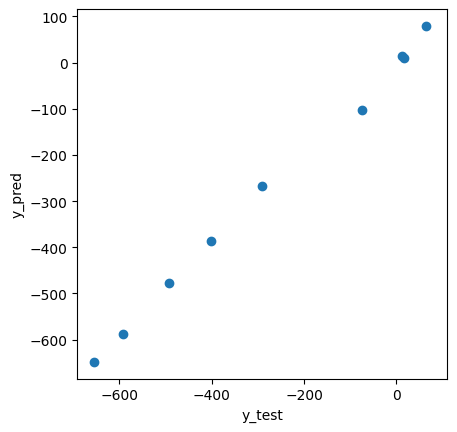

In [13]:
y_pred = clf.predict(X_test)

y_pred = y_pred.ravel()
outdata = pd.DataFrame({labels[0]:y_test[labels].to_numpy().ravel(), 'Predizione':y_pred})
display(outdata)

print ('\nScore = ', clf.score(X_test, y_test))

plt.plot(y_pred, y_test[labels].to_numpy().ravel(),'o')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.axis('square')
plt.show()

## **Esercizio**
Nel Jupyter notebook ML_example_1.ipynb avete imparato a usare gli alberi decisionali per eseguire la regressione. Si addestri un albero decisionale di regressione per risolvere lo stesso problema di questo esempio e si confrontino i risultati.